# MLP
MLP, K=5, lncRNA.

Droput.

In [60]:
from datetime import datetime
print(datetime.now())

2023-04-06 16:45:03.392607


In [61]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [62]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.optimizers import SGD
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=120 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000 # NOT USED FOR MLP
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [63]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [64]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [65]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        # NREPEAT = str('N'*MAXLEN) # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # No MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [66]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    drop1  = Dropout(.2)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(drop1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)

    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [67]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 16:45:04.818707
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 64)                65664     
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dense_156 (Dense)           (None, 64)                4160      
                                                                 
 dense_157 (Dense)           (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [68]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [69]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 16:45:05.018262
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 16:45:14.215360
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 16:45:14.230067
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 16:45:14.341830


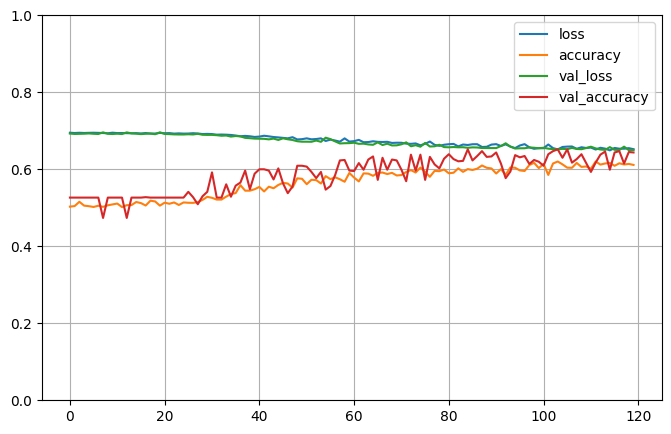


Testing # 1 1
2023-04-06 16:46:08.979786
2023-04-06 16:46:08.979833
PREDICT
2023-04-06 16:46:08.991356
Test 1:0 458:412 52.64%
Predict 1:0 558:312 64.14%
Test sizes (870, 1025) (870,)
Distrib of scores: 0.54224974 mean 0.11089024 std
Range of scores: 0.21837835 to 0.8443259
Score threshold 0.5
Confusion matrix
 [[207 205]
 [105 353]]
Normalized matrix
 [[0.23793103 0.23563218]
 [0.12068966 0.40574713]]


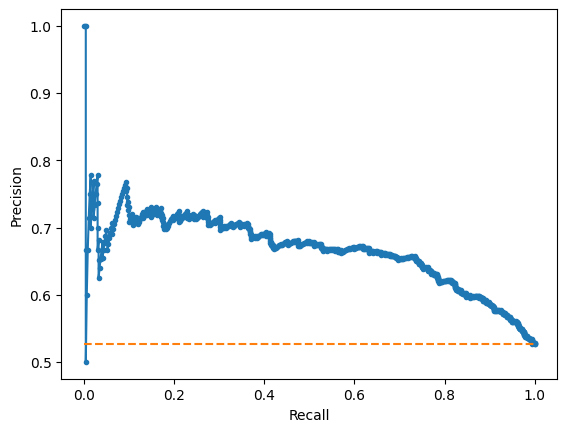

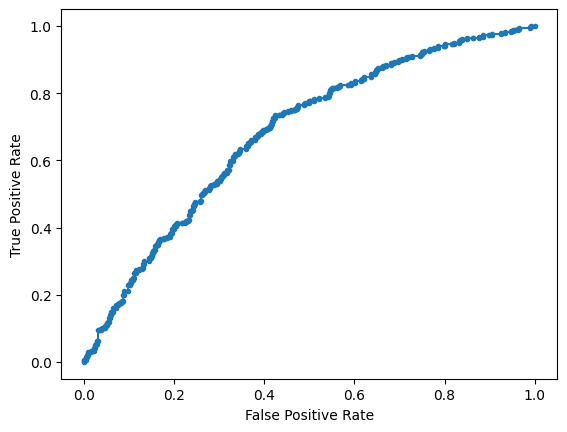

Accuracy: 64.37% Precision: 63.26% Recall: 77.07%
F1: 69.49% MCC: 0.2844
AUPRC: 66.65% AUROC: 68.00%
 accuracy [64.36781609195403]
 precision [63.261648745519715]
 recall [77.07423580786026]
 F1 [69.48818897637796]
 MCC [0.28439321176355353]
 AUPRC [66.64667250712584]
 AUROC [67.99508203671513]

Training # 1 2
2023-04-06 16:46:09.578347
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 16:46:09.599477
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 16:46:09.681239


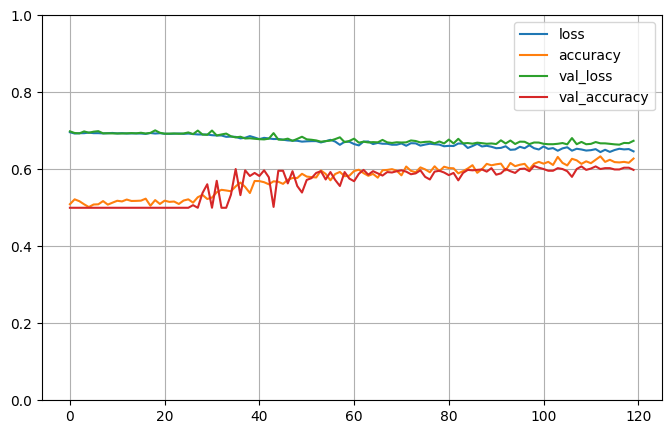


Testing # 1 2
2023-04-06 16:47:05.405284
2023-04-06 16:47:05.405337
PREDICT
2023-04-06 16:47:05.420077
Test 1:0 442:442 50.00%
Predict 1:0 643:241 72.74%
Test sizes (884, 1025) (884,)
Distrib of scores: 0.56945395 mean 0.1188327 std
Range of scores: 0.2430861 to 0.87207377
Score threshold 0.5
Confusion matrix
 [[164 278]
 [ 77 365]]
Normalized matrix
 [[0.18552036 0.31447964]
 [0.08710407 0.41289593]]


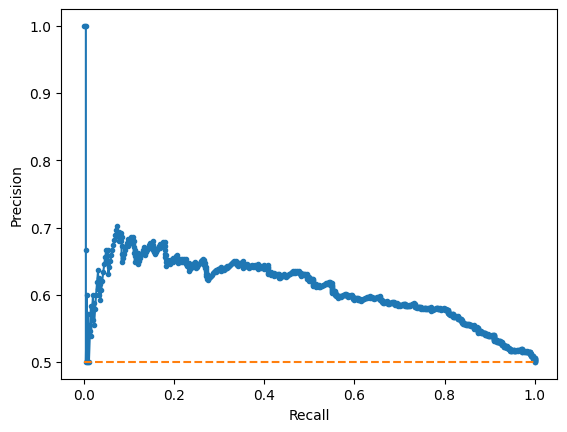

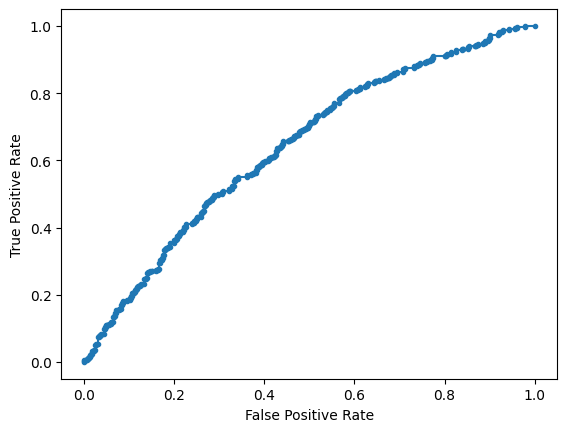

Accuracy: 59.84% Precision: 56.77% Recall: 82.58%
F1: 67.28% MCC: 0.2210
AUPRC: 60.91% AUROC: 64.05%
 accuracy [59.841628959276015]
 precision [56.7651632970451]
 recall [82.57918552036199]
 F1 [67.2811059907834]
 MCC [0.22100660076189044]
 AUPRC [60.91136555648997]
 AUROC [64.05069511271269]

Training # 1 3
2023-04-06 16:47:06.044815
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 16:47:06.067311
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 16:47:06.157976


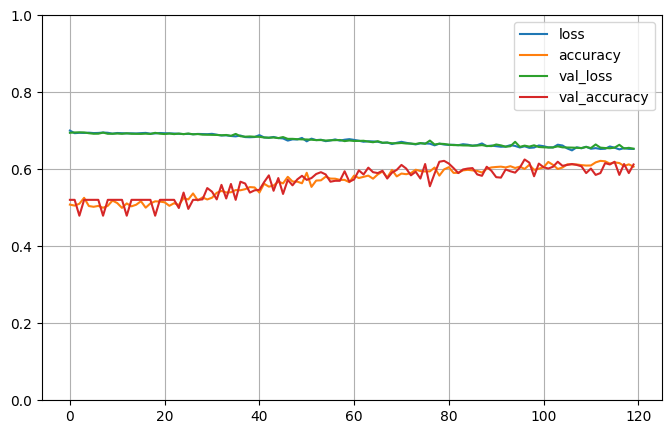


Testing # 1 3
2023-04-06 16:47:58.694590
2023-04-06 16:47:58.694975
PREDICT
2023-04-06 16:47:58.702710
Test 1:0 442:407 52.06%
Predict 1:0 479:370 56.42%
Test sizes (849, 1025) (849,)
Distrib of scores: 0.52761537 mean 0.11237639 std
Range of scores: 0.18415137 to 0.82774633
Score threshold 0.5
Confusion matrix
 [[224 183]
 [146 296]]
Normalized matrix
 [[0.26383981 0.2155477 ]
 [0.17196702 0.34864547]]


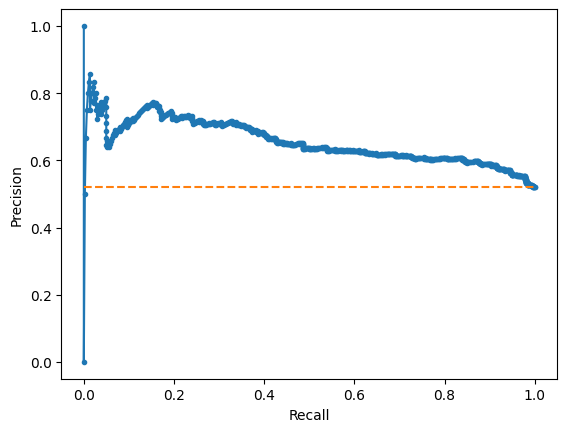

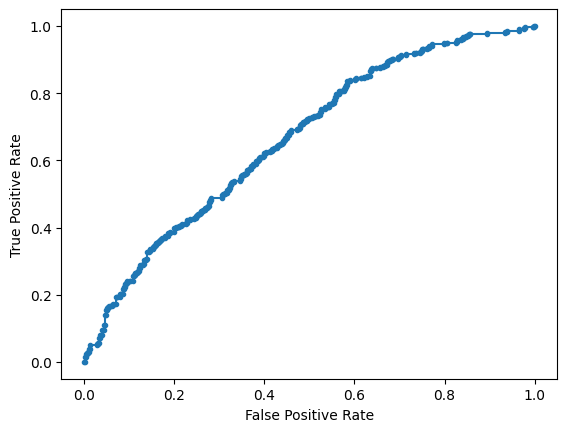

Accuracy: 61.25% Precision: 61.80% Recall: 66.97%
F1: 64.28% MCC: 0.2217
AUPRC: 65.45% AUROC: 66.44%
 accuracy [61.24852767962309]
 precision [61.79540709812108]
 recall [66.9683257918552]
 F1 [64.27795874049946]
 MCC [0.2216994737858781]
 AUPRC [65.45071581809778]
 AUROC [66.44301644301645]

Training # 1 4
2023-04-06 16:47:59.579050
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 16:47:59.601767
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 16:47:59.724420


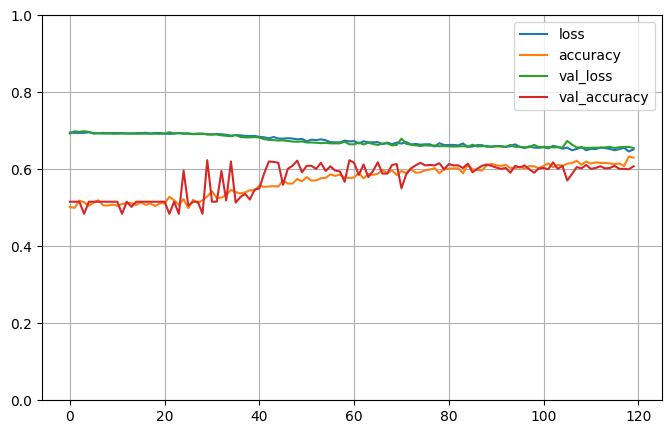


Testing # 1 4
2023-04-06 16:48:55.911699
2023-04-06 16:48:55.911749
PREDICT
2023-04-06 16:48:55.921443
Test 1:0 459:431 51.57%
Predict 1:0 462:428 51.91%
Test sizes (890, 1025) (890,)
Distrib of scores: 0.5138618 mean 0.11649874 std
Range of scores: 0.1895011 to 0.8641875
Score threshold 0.5
Confusion matrix
 [[255 176]
 [173 286]]
Normalized matrix
 [[0.28651685 0.19775281]
 [0.19438202 0.32134831]]


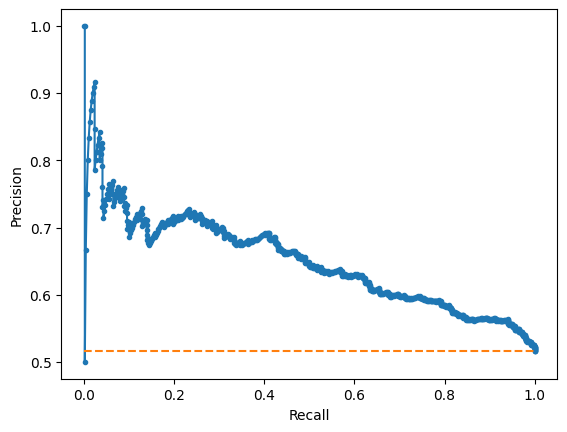

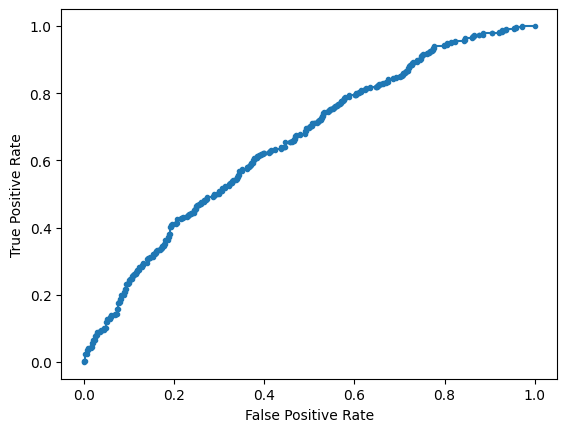

Accuracy: 60.79% Precision: 61.90% Recall: 62.31%
F1: 62.11% MCC: 0.2148
AUPRC: 64.98% AUROC: 65.47%
 accuracy [60.78651685393258]
 precision [61.904761904761905]
 recall [62.309368191721134]
 F1 [62.106406080347455]
 MCC [0.21479150670104885]
 AUPRC [64.9836053060555]
 AUROC [65.46512392015327]

Training # 1 5
2023-04-06 16:48:56.527456
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 16:48:56.553933
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 16:48:56.650846


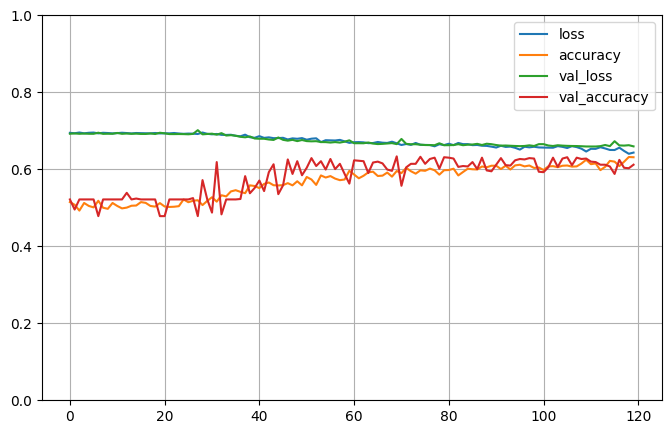


Testing # 1 5
2023-04-06 16:49:53.684473
2023-04-06 16:49:53.684521
PREDICT
2023-04-06 16:49:53.695564
Test 1:0 457:419 52.17%
Predict 1:0 543:333 61.99%
Test sizes (876, 1025) (876,)
Distrib of scores: 0.54282624 mean 0.12056931 std
Range of scores: 0.23559123 to 0.8720447
Score threshold 0.5
Confusion matrix
 [[206 213]
 [127 330]]
Normalized matrix
 [[0.23515982 0.24315068]
 [0.14497717 0.37671233]]


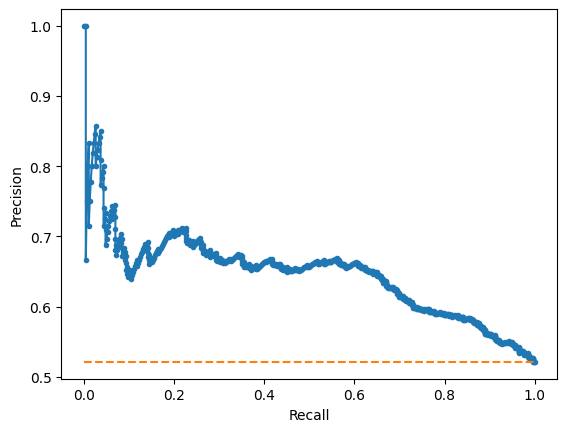

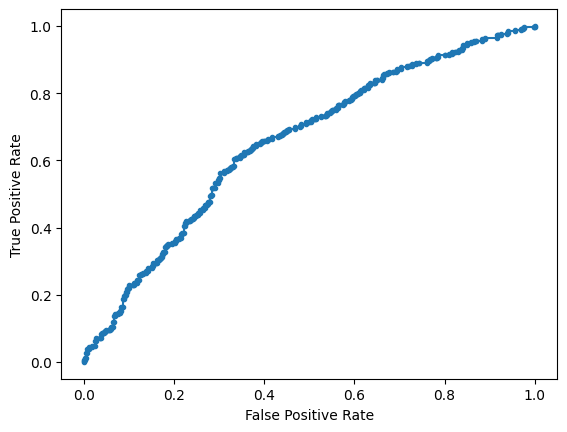

Accuracy: 61.19% Precision: 60.77% Recall: 72.21%
F1: 66.00% MCC: 0.2200
AUPRC: 64.64% AUROC: 65.27%
 accuracy [61.18721461187214]
 precision [60.773480662983424]
 recall [72.21006564551422]
 F1 [66.0]
 MCC [0.21996014170006944]
 AUPRC [64.64499297750692]
 AUROC [65.26793501250762]

Training # 2 1
2023-04-06 16:49:54.310369
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 16:49:54.334562
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 16:49:54.419534


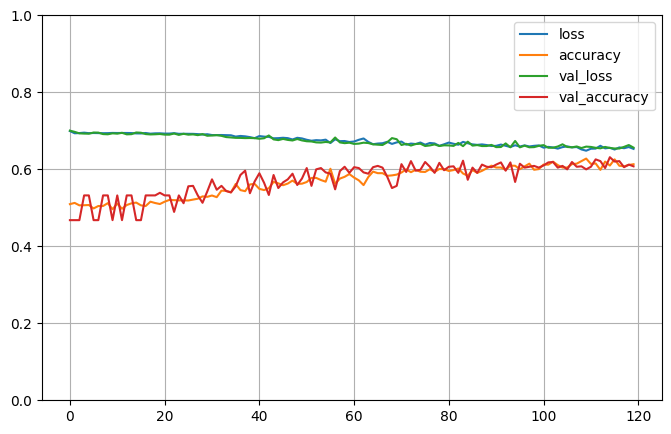


Testing # 2 1
2023-04-06 16:51:17.692778
2023-04-06 16:51:17.692830
PREDICT
2023-04-06 16:51:17.708962
Test 1:0 472:415 53.21%
Predict 1:0 404:483 45.55%
Test sizes (887, 1025) (887,)
Distrib of scores: 0.49723703 mean 0.11047551 std
Range of scores: 0.19757754 to 0.80908895
Score threshold 0.5
Confusion matrix
 [[275 140]
 [208 264]]
Normalized matrix
 [[0.31003382 0.1578354 ]
 [0.23449831 0.29763247]]


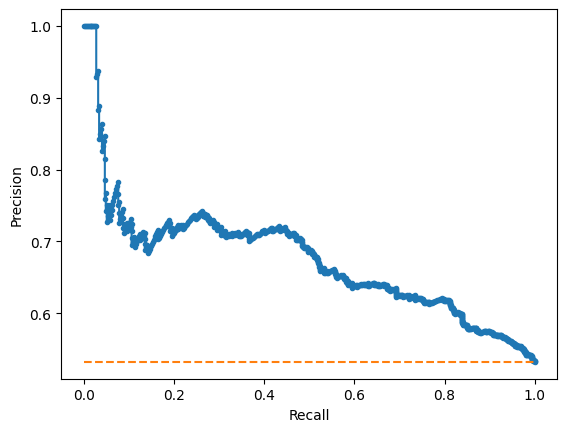

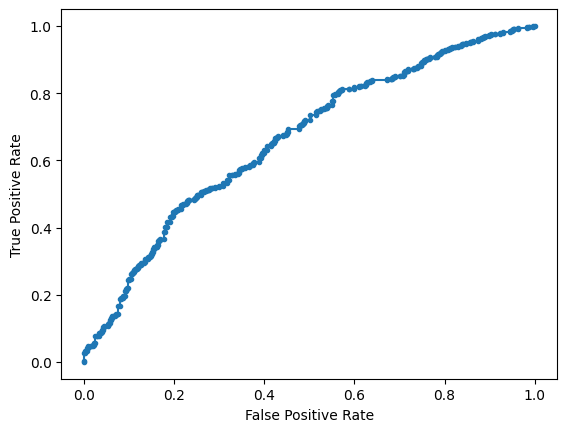

Accuracy: 60.77% Precision: 65.35% Recall: 55.93%
F1: 60.27% MCC: 0.2224
AUPRC: 67.53% AUROC: 66.25%
 accuracy [60.766629086809466]
 precision [65.34653465346535]
 recall [55.932203389830505]
 F1 [60.273972602739725]
 MCC [0.22239767351376144]
 AUPRC [67.53040000823036]
 AUROC [66.245150091893]

Training # 2 2
2023-04-06 16:51:18.319063
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 16:51:18.336451
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 16:51:18.426556


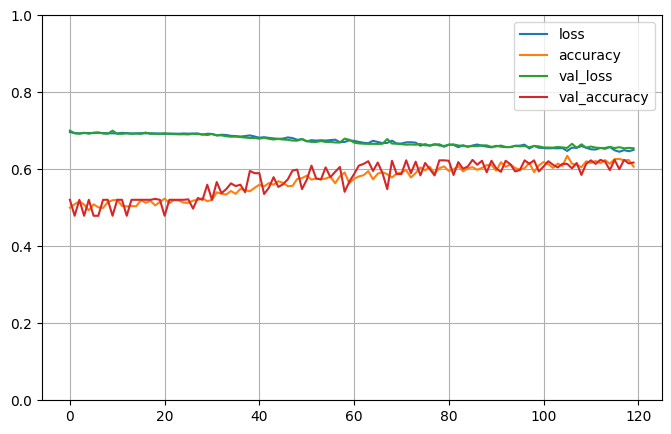


Testing # 2 2
2023-04-06 16:52:14.428353
2023-04-06 16:52:14.428400
PREDICT
2023-04-06 16:52:14.439303
Test 1:0 452:416 52.07%
Predict 1:0 420:448 48.39%
Test sizes (868, 1025) (868,)
Distrib of scores: 0.50323117 mean 0.12317632 std
Range of scores: 0.17487457 to 0.86347926
Score threshold 0.5
Confusion matrix
 [[266 150]
 [182 270]]
Normalized matrix
 [[0.30645161 0.17281106]
 [0.20967742 0.31105991]]


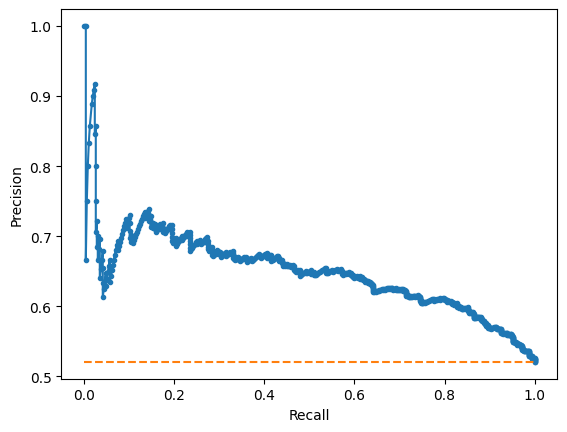

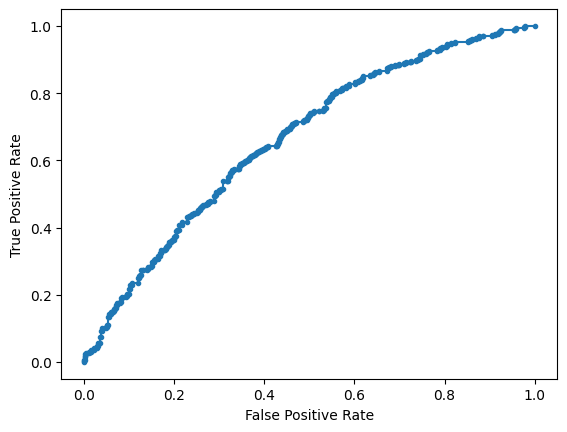

Accuracy: 61.75% Precision: 64.29% Recall: 59.73%
F1: 61.93% MCC: 0.2367
AUPRC: 64.98% AUROC: 66.15%
 accuracy [61.75115207373272]
 precision [64.28571428571429]
 recall [59.73451327433629]
 F1 [61.926605504587165]
 MCC [0.2366876625609735]
 AUPRC [64.97984679343874]
 AUROC [66.15150612661674]

Training # 2 3
2023-04-06 16:52:15.049182
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 16:52:15.074851
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 16:52:15.176220


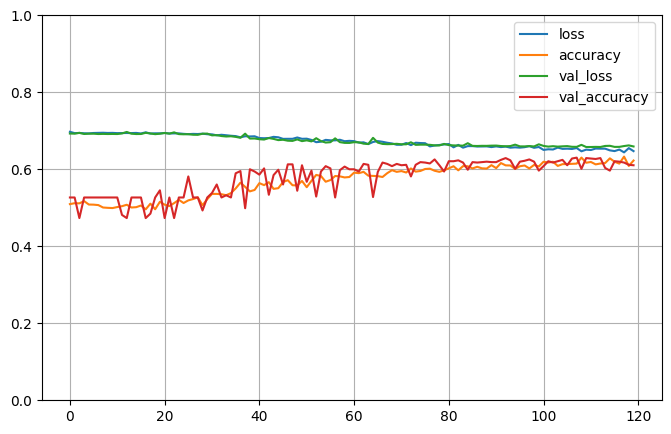


Testing # 2 3
2023-04-06 16:53:38.358648
2023-04-06 16:53:38.359056
PREDICT
2023-04-06 16:53:38.367549
Test 1:0 453:407 52.67%
Predict 1:0 414:446 48.14%
Test sizes (860, 1025) (860,)
Distrib of scores: 0.49713343 mean 0.11996428 std
Range of scores: 0.18027899 to 0.8337218
Score threshold 0.5
Confusion matrix
 [[259 148]
 [187 266]]
Normalized matrix
 [[0.30116279 0.17209302]
 [0.21744186 0.30930233]]


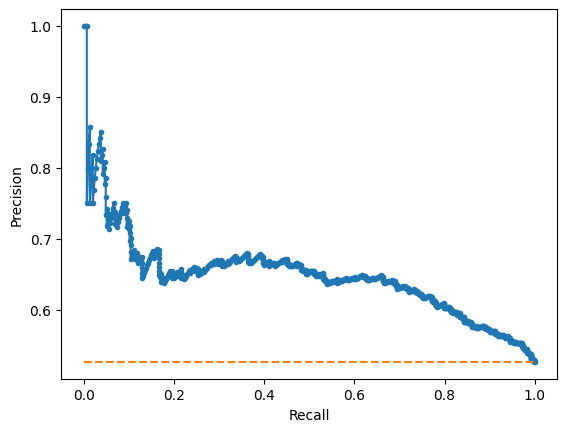

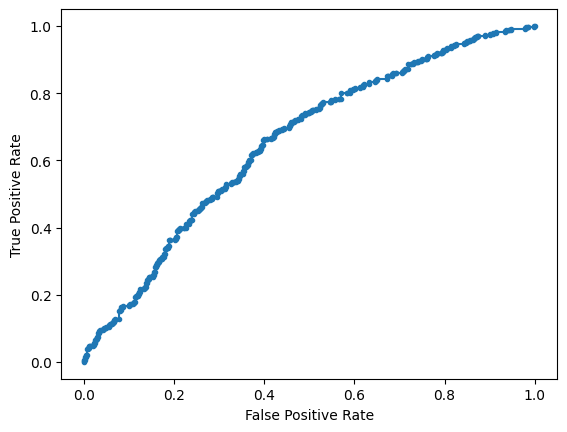

Accuracy: 61.05% Precision: 64.25% Recall: 58.72%
F1: 61.36% MCC: 0.2234
AUPRC: 64.84% AUROC: 65.32%
 accuracy [61.04651162790697]
 precision [64.25120772946859]
 recall [58.719646799117]
 F1 [61.36101499423299]
 MCC [0.22339477408569816]
 AUPRC [64.84174352629782]
 AUROC [65.31884081552955]

Training # 2 4
2023-04-06 16:53:38.989316
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 16:53:39.009151
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 16:53:39.098379


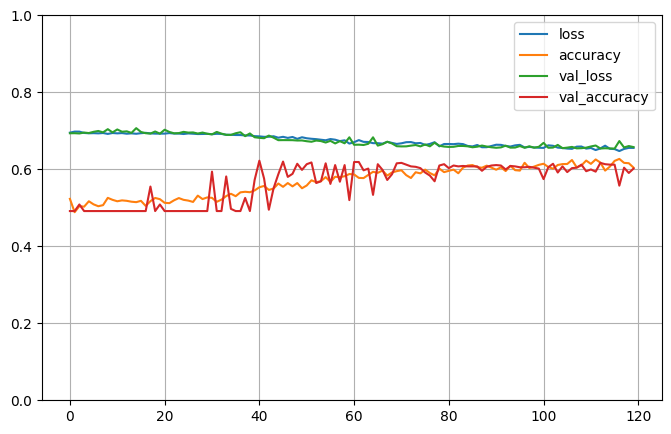


Testing # 2 4
2023-04-06 16:55:02.452092
2023-04-06 16:55:02.452500
PREDICT
2023-04-06 16:55:02.466089
Test 1:0 432:447 49.15%
Predict 1:0 550:329 62.57%
Test sizes (879, 1025) (879,)
Distrib of scores: 0.5322148 mean 0.10892678 std
Range of scores: 0.2331601 to 0.83203304
Score threshold 0.5
Confusion matrix
 [[213 234]
 [116 316]]
Normalized matrix
 [[0.24232082 0.2662116 ]
 [0.13196815 0.35949943]]


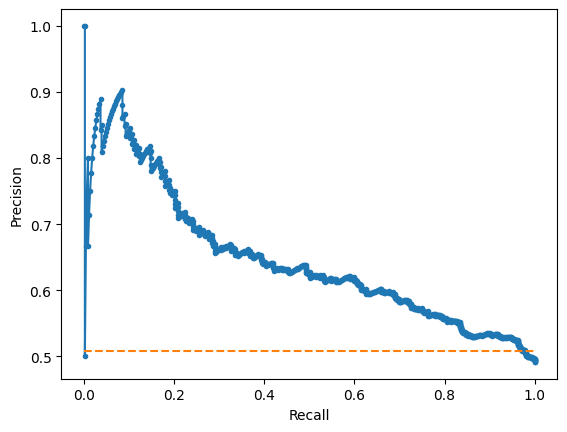

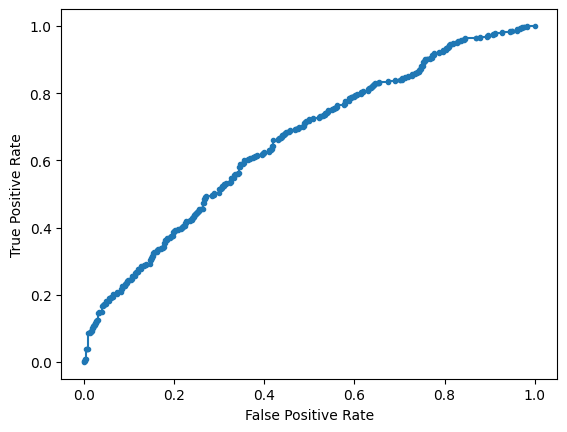

Accuracy: 60.18% Precision: 57.45% Recall: 73.15%
F1: 64.36% MCC: 0.2149
AUPRC: 64.66% AUROC: 65.69%
 accuracy [60.18202502844141]
 precision [57.45454545454546]
 recall [73.14814814814815]
 F1 [64.35845213849288]
 MCC [0.21486319516777377]
 AUPRC [64.66387393616621]
 AUROC [65.6868837517607]

Training # 2 5
2023-04-06 16:55:03.462575
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 16:55:03.496502
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 16:55:03.623924


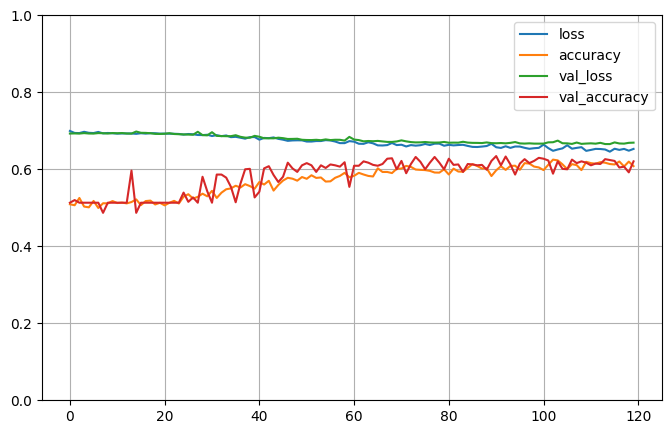


Testing # 2 5
2023-04-06 16:56:27.413306
2023-04-06 16:56:27.413352
PREDICT
2023-04-06 16:56:27.426030
Test 1:0 449:426 51.31%
Predict 1:0 585:290 66.86%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5595295 mean 0.118118495 std
Range of scores: 0.2533412 to 0.8790997
Score threshold 0.5
Confusion matrix
 [[192 234]
 [ 98 351]]
Normalized matrix
 [[0.21942857 0.26742857]
 [0.112      0.40114286]]


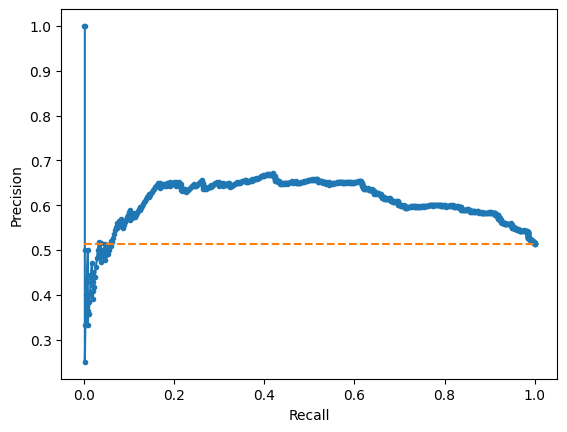

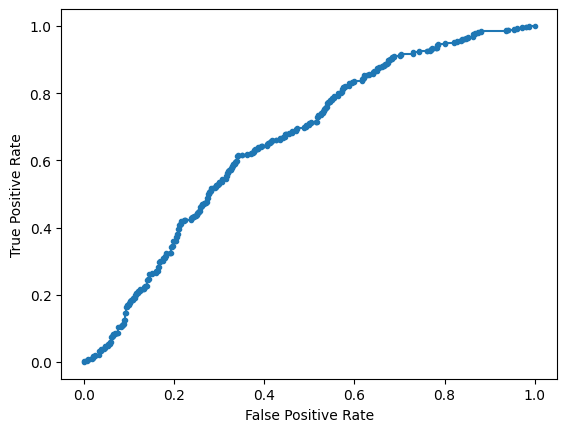

Accuracy: 62.06% Precision: 60.00% Recall: 78.17%
F1: 67.89% MCC: 0.2468
AUPRC: 60.99% AUROC: 65.76%
 accuracy [62.05714285714286]
 precision [60.0]
 recall [78.17371937639199]
 F1 [67.8916827852998]
 MCC [0.24681102538399327]
 AUPRC [60.987103992042776]
 AUROC [65.76011376350158]
2023-04-06 16:56:28.055755


In [70]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [71]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.32% std 1.26
 precision mean 61.58% std 2.89
 recall mean 68.68% std 9.26
 F1 mean 64.50% std 3.10
 MCC mean 0.2306 std 0.0213
 AUPRC mean 64.56% std 2.12
 AUROC mean 65.84% std 1.01
 accuracy [[64.36781609195403], [59.841628959276015], [61.24852767962309], [60.78651685393258], [61.18721461187214], [60.766629086809466], [61.75115207373272], [61.04651162790697], [60.18202502844141], [62.05714285714286]]
 precision [[63.261648745519715], [56.7651632970451], [61.79540709812108], [61.904761904761905], [60.773480662983424], [65.34653465346535], [64.28571428571429], [64.25120772946859], [57.45454545454546], [60.0]]
 recall [[77.07423580786026], [82.57918552036199], [66.9683257918552], [62.309368191721134], [72.21006564551422], [55.932203389830505], [59.73451327433629], [58.719646799117], [73.14814814814815], [78.17371937639199]]
 F1 [[69.48818897637796], [67.2811059907834], [64.27795874049946], [62.106406080347455], [66.0], [60.273972602739725], [61.926605504587165], [61.36